In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import os, sys, re, pickle, glob
import urllib.request
import zipfile
from pathlib import Path

import IPython.display as ipd
from tqdm import tqdm
import librosa

# Elliot Linsey : 210764484 : Advanced Solution

We have been provided with a dataset containing audio files of either hums or whistles of recognisable songs or pieces of music. The purpose of this advanced solution is to create a machine learning pipeline that can predict whether an audio file fed into it is one of a number of pieces of music, these being themes from:
* The Lion King
* The Greatest Showman
* Star Wars
* Frozen
* Singing in the Rain
* Harry Potter
* The Pink Panther
* Mamma Mia

An interesting aspect of this particular dataset and problem in general, is that we do not have equal numbers of hums or whistles with there being far more hums in the dataset. Depending on what features we extract from the data, this may have an effect on our ability to predict what tune is being played.  

## Pipeline Description and Methodology

The pipeline will consist of an input stage, a transformation stage, feature extraction stage and a modelling stage leading to a prediction as the output. For the dataset we have received, some data cleaning techniques were used to rename all files into a pattern of "Participant ID" - "Interpretation Type (Whistle or Hum)" - "Interpretation Number (1-4)" - "Song Title". 

The input stage will take the raw .wav audio file, the transformation stage will convert the wav file into a numpy array using librosa, then shorten it to 15 seconds from the first onset. The feature extraction stage will extract the spectral centroids from the audio file. The model that will be used is a Random Forest Classifier to attempt to separate the classes by this feature and make a prediction. In addition to this, we shall use gridsearch and cross validation to find the optimal parameters for this problem. 

A spectral centroid indicates where the center of mass of the spectrum is located and is calculated as the weighted mean of the frequencies present in the signal. Hopefully, each song type will have similar spectral centroid patterns that will make it possible for the classifier to distinguish between them. 

I have decided to use a random forest classifier due to its ability to make multiple classifications. As it aggregates the results of many random trees the model should be less prone to overfitting, this is important due to the high number of features that will be extracted with spectral centroids.

To train the model, we shall split the dataset into training and testing sets, with 80% being used for training and 20% being used for testing. Then we will use gridsearch and cross validation to determine the optimal parameters for RFC on our dataset and apply it to our test dataset to generate an F-score. 

To further our evaluation of the ML model, we shall generate a confusion matrix that details the true positive, false positive, true negative and false negative predictions. We shall also create a report detailing the precision and recall of our model predictions. 

## Dataset

For this experiment I am using all the files from the available data which amounts to 3330 audiofiles, which amounts to approximately 420 per class. There are around 300 hums and 100 whistles in each folder, so hums are around 3 times more prevalent which may lead our classifier to skew more towards hums when being trained on the data. 

In [3]:
sample_path = '/Users/ellio/Documents/MLHW/All_1/*.wav'
files = glob.glob(sample_path)
len(files)

3330

Using pandas I create a reference dataframe that contains all the relevant metadata about the audiofiles, this will be used to generate the labels array by locating the file_id's corresponding song value. 

In [4]:
MLENDHW_table = [] 

for file in files:
    file_name = file.split('\\')[-1]
    participant_ID = file_name.split('_')[0]
    interpretation_type = file_name.split('_')[1]
    interpretation_number = file_name.split('_')[2]
    song = re.search("\w+?(?=\.wav)",file_name.split('_')[3]).group()
    MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id')
#len(MLENDHW_df[(MLENDHW_df['interpretation']=='hum')])
MLENDHW_df.head()

participant interpretation number    song
file_id                                                        
S100_hum_1_Hakuna.wav        S100            hum      1  Hakuna
S100_hum_1_Potter.wav        S100            hum      1  Potter
S100_hum_1_Rain.wav          S100            hum      1    Rain
S100_hum_2_Frozen.wav        S100            hum      2  Frozen
S100_hum_2_Hakuna.wav        S100            hum      2  Hakuna

## Data Transformation

I use onset detect to find the time of the first sound input, this will be useful to trim down the audio files into the same length for comparison. The plot is a visualisation of the onsets, the red dotted lines being their placement over the timeseries.

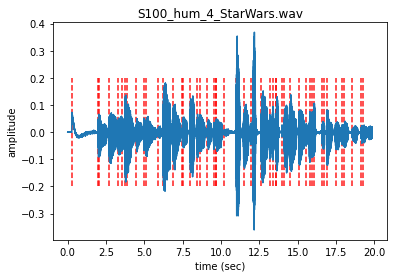

In [5]:
fs = None
n = 15
x, fs = librosa.load(files[n],sr=fs)
times = librosa.onset.onset_detect(y=x, sr=fs, units='time')
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.vlines(times, -0.20, 0.20,color='r', alpha=0.9,
           linestyle='--', label='Onsets')
title = files[n].split('\\')[-1]
plt.title(title)
plt.show()

Below I create a function that performs some data transformation. trim_audio() finds the first onset, essentially removing any silence at the beginning of the audio file, from here it takes the next 15 seconds of the track so that all subsequent arrays will be the same length for comparison. If the audiofile is less than 15 seconds, it appends 0s to the end of the file to pad the length. 

In [6]:
fs=None
x,fs=librosa.load(files[0],sr=fs)

def trim_audio(audiofile):
    times = librosa.onset.onset_detect(y=audiofile, sr=fs, units='time')
    t1 = int(times[0]*44100)
    t2 = t1+15*44100
    if len(audiofile[t1:t2])!=661500:
        audiofile = np.append(audiofile,[0]*(661500-len(audiofile[t1:t2])))
    return audiofile[t1:t2]

Using a file from the dataset, we can extract the spectral centroids into a numpy array. The length of this array is the number of spectral centroids and therefore the number of features to be used by the random forest classifier. At 1292, this is a lot of features and may lead to the model being at risk of overfitting. To combat this, I create a function mean_maker() that finds the mean centroid value for each second of audio, resulting in 15 features, however this may be less accurate than the original 1292. 

In [7]:
cent = librosa.feature.spectral_centroid(y=trim_audio(x), sr=fs, n_fft=7603)
print('Number of features = ' + str(len(cent[0])))

Number of features = 1292


In [8]:
def mean_maker(cent):
    lst = []
    lst2 = []
    x = 0
    for i in range(15):
        lst.append(cent[x:x+87])
        x+=87
    for x in lst:
        lst2.append(np.mean(x))
    return lst2
test = mean_maker(cent[0])
print('Reduced number of features = ' + str(len(test)))

Reduced number of features = 15


## Data Visualisation

I also investigate the spectral centroids of the songs in the dataset. Below are the plotted representations of each different song titles' spectral centroid on a spectrogram. They are all taken from the same participant for comparison purposes. What we can see is that there are differences and similarities between each songs spectral centroids, most start high around 4096hz then dip to 2048 with peaks and troughs scattered throughout until the end. Some of the patterns may be due to each individual's recording, for example a mouse click at the beginning may be present in all of that one individuals' recordings. This could lead the classifier to learn the wrong pattern from the audiofile and apply it incorrectly. Will the classifier be able to see each songs' true pattern and make accurate predictions?

In [9]:
import librosa.display
def spectro(audiofile):
    title = audiofile.split('\\')[-1]
    fs=None
    audiofile,fs = librosa.load(audiofile,sr=fs)
    audiofile = trim_audio(audiofile)
    cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs, n_fft=7603)
    S, phase = librosa.magphase(librosa.stft(y=audiofile))
    librosa.feature.spectral_centroid(S=S)
    freqs, times, D = librosa.reassigned_spectrogram(audiofile, fill_nan=True)
    times = librosa.times_like(cent)
    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis='log', x_axis='time',ax=ax,sr=fs,)
    ax.plot(times, cent.T, label='Spectral centroid', color='w',)
    ax.set_title(title)

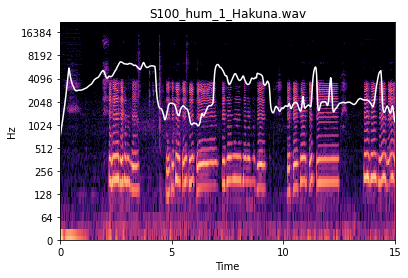

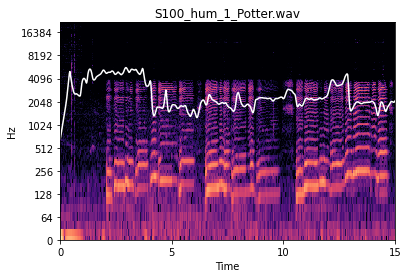

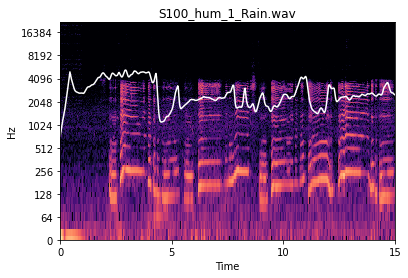

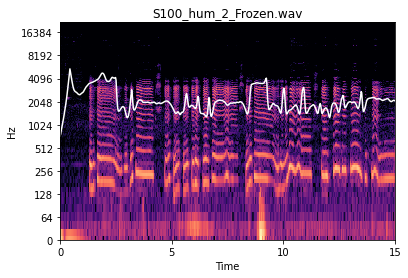

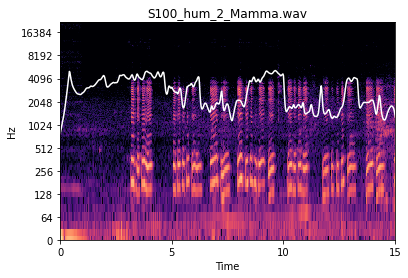

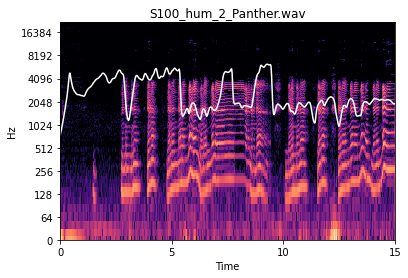

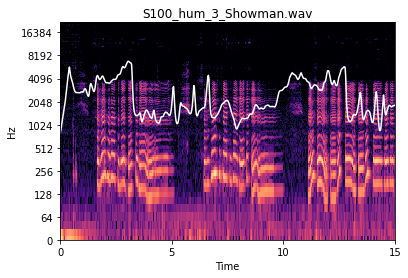

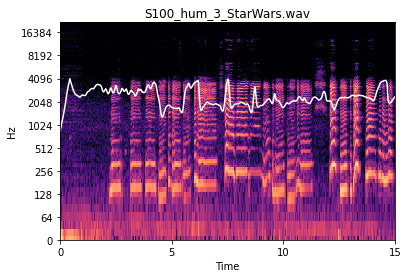

In [10]:
spectro(files[0])
spectro(files[1])
spectro(files[2])
spectro(files[3])
spectro(files[5])
spectro(files[6])
spectro(files[9])
spectro(files[10])

## Feature Extraction

The get_centroids() function loads the input wav file using librosa, then shortens it to 15 seconds using trim_audio, then it extracts the spectral centroids. The labeler() function is used within this get_centroids() function, it uses the previously created pandas dataframe to create the class array containing the labels of each file so that we can find how accurate our classifier is on a training and test dataset. 

The second version, get_centroids2(), utilises the previous function mean_maker() to reduce the number of features by finding the mean of the spectral centroids to result in 15 features. The whole process results in two X matrices and two y arrays, one for the full dataset and another for the reduced dataset. 

In [11]:
def labeler(fileID,labels_file=MLENDHW_df):
    if labels_file.loc[fileID]['song']=='Potter':
        return 'Potter'
    elif labels_file.loc[fileID]['song']=='StarWars':
        return 'StarWars'
    elif labels_file.loc[fileID]['song']=='Hakuna':
        return 'Hakuna'
    elif labels_file.loc[fileID]['song']=='Frozen':
        return 'Frozen'
    elif labels_file.loc[fileID]['song']=='Showman':
        return 'Showman'
    elif labels_file.loc[fileID]['song']=='Rain':
        return 'Rain'
    elif labels_file.loc[fileID]['song']=='Panther':
        return 'Panther'
    else:
        return 'Mamma'

# def labeler2(fileID,labels_file=MLENDHW_df):
#     if labels_file.loc[fileID]['interpretation']=='hum':
#         return False
#     else:
#         return True

In [12]:
def get_centroids(files, labels_file=MLENDHW_df):
    X = []
    y = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        X.append(cent)
        y.append(yi)
    return np.squeeze(np.array(X)),y

In [13]:
def get_centroids2(files, labels_file=MLENDHW_df):
    X = []
    y = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        cent = mean_maker(cent[0])
        X.append(cent)
        y.append(yi)
    return np.squeeze(np.array(X)),y

Using the get_centroids functions results in two numpy arrays, to avoid having to run it each time for the notebook we save them to .npy files and load them in. 

In [14]:
#X,y = get_centroids(files)
#X_2,y_2 = get_centroids2(files)
X = np.load('X_all.npy')
y = np.load('y_all.npy')
X_2 = np.load('X_means.npy')
y_2 = np.load('y_means.npy')

As we can see, the X matrix contains 3330 rows and 1292 columns (or features). Due to this, we are at a high risk of overfitting our data to the training set. 

The X_2 matrix contains the same number of rows but the reduced number of features with only 15, this may prevent overfitting but it will also make gridsearching for optimal hyperparameters less CPU intensive and time consuming. 

In [15]:
print('X matrix shape = ' +str(X.shape))
print('X_2 matrix shape = ' +str(X_2.shape))

X matrix shape = (3330, 1292)
X_2 matrix shape = (3330, 15)


## Experiment

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Splitting our data then fitting a baseline random forest classifier confirms our suspicions that we have overfit to our training data. We still achieve a test score of around 0.52 which is better than selecting a random choice. In this case, as we have 8 classes a random selection probability would be 1/8 or 0.125. Our test score is higher than this so we can infer that our base classifier has some ability to discern the classes and make the correct prediction. 

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('Train score = ' + str(clf.score(X_train,y_train)))
print('Test score = ' + str(clf.score(X_test,y_test)))
#clf.score(X_train,y_train)

Train score = 1.0
Test score = 0.5180180180180181


A clearer demonstration of the classifier is achieved by using a confusion matrix. As we can see from the diagonal line our predictor was able to recognise the classes to some degree, with all correct labels having been predicted the most out of each column. 

What we can also see is where our predictor went wrong, with Frozen being confused for Potter and Rain the most, Mamma also being confused for Hakuna and so on through the confusion matrix. This infers that, at least when using spectral centroids, there may be some overlap between these songs which causes difficulty in this specific random forest classifier to accurately differentiate them. 

In [18]:
from sklearn.metrics import confusion_matrix
X_predictions = clf.predict(X_test)
confusion = confusion_matrix(y_test,X_predictions)
confm = pd.DataFrame({
    'Pred. Frozen': confusion[:,0],
    'Pred. Hakuna': confusion[:,1],
    'Pred. Mamma': confusion[:,2],
    'Pred. Panther': confusion[:,3],
    'Pred. Potter': confusion[:,4],
    'Pred. Rain': confusion[:,5],
    'Pred. Showman': confusion[:,6],
    'Pred. StarWars': confusion[:,7],
}, index=['Act. Frozen','Act. Hakuna','Act. Mamma','Act. Panther',
         'Act. Potter','Act. Rain','Act. Showman','Act. StarWars',])
confm

Pred. Frozen  Pred. Hakuna  Pred. Mamma  Pred. Panther  \
Act. Frozen              39             4            9              8   
Act. Hakuna               8            56           10              3   
Act. Mamma                7             5           41              9   
Act. Panther              6             3            6             48   
Act. Potter              17             2            5              9   
Act. Rain                17             6            9              3   
Act. Showman              5             1            3              1   
Act. StarWars             8             4            4              5   

               Pred. Potter  Pred. Rain  Pred. Showman  Pred. StarWars  
Act. Frozen               5           8              1               7  
Act. Hakuna               4          10              6               6  
Act. Mamma                6           2              2               0  
Act. Panther              4           2              1               3  
Act. Potter              33           8              5               3  
Act. Rain                10          42              3               1  
Act. Showman              5           5             48              11  
Act. StarWars             9           7             10              38

It is more useful to dive deeper into the results, rather than to just use overall accuracy. By calculating the precision and recall we can see how effective our model was at predicting each class. 

From below, we can see that the precision and recall varied quite signifantly between some of the classes. Using Hakuna as an example, a 70% precision score means that for every Mamma prediction that the model made, 69% of them were truly Mamma with the other 31% being false positives. A 54% recall score means that for every actual Mamma, 54% of them were predicted Mamma and the other 46% were predicted another class. The F-score is calculated from these two scores using the formula (2 * precision * recall)/(precision + recall) to give a single value that gives a measure of accuracy. The support is simply the number of occurrences of that label in the y label array. 

Some of the classes also have larger differences between their precision and recall scores which implies that, using Hakuna as an example again, when we make a prediction that the song is Hakuna, we can be 69% certain that it is true. However, we missed 54% of the actual Hakuna songs when making our predictions and labelled them as false negatives. From these scores, we can say that our model is more effective at predicting some specific classes from the spectral centroids and that we can have more confidence with some predictions than others, for example we can have more trust in our classifier when it predicts Hakuna (precision of 69%) compared to Frozen (precision of 36%). 

In [19]:
from sklearn.metrics import precision_recall_fscore_support
report = np.array(precision_recall_fscore_support(y_test,X_predictions))
class_report = pd.DataFrame({
    'Songs':['Frozen','Hakuna','Mamma','Panther','Potter','Rain','Showman','StarWars'],
    'Precision':report[0],
    'Recall':report[1],
    'Fscore':report[2],
    'Support':report[3],
}).set_index('Songs')
class_report

Precision    Recall    Fscore  Support
Songs                                           
Frozen     0.364486  0.481481  0.414894     81.0
Hakuna     0.691358  0.543689  0.608696    103.0
Mamma      0.471264  0.569444  0.515723     72.0
Panther    0.558140  0.657534  0.603774     73.0
Potter     0.434211  0.402439  0.417722     82.0
Rain       0.500000  0.461538  0.480000     91.0
Showman    0.631579  0.607595  0.619355     79.0
StarWars   0.550725  0.447059  0.493506     85.0

Using the reduced X matrix with only 15 features gives a similar test score to the full matrix above with 1292 features. As before, it is also highly overfitted. 

In [33]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X_2,y_2,test_size=0.2)
clf.fit(X_train2,y_train2)
print('Train score = ' + str(clf.score(X_train2,y_train2)))
print('Test score = ' + str(clf.score(X_test2,y_test2)))

Train score = 1.0
Test score = 0.551051051051051


There is a very large difference when scaling the full feature dataset and the reduced feature dataset. The full sets' results do not change significantly when scaled and the model applied. However, the reduced datasets' accuracy drops to around 12.5% when scaled, performing no better than random chance. This could be expected as the reduced dataset is a dataset full of means, when scaling you are then calculating the mean of these means, minusing this away and dividing by the standard deviation. This level of reduction must be too far for the classifier and therefore it cannot find any relevant patterns. 

In [31]:
mean = X_train.mean(0)
sd =  X_train.std(0)
X_train_scale = (X_train-mean)/sd
X_test_scale  = (X_test-mean)/sd
clf.fit(X_train_scale,y_train)
print('Scaled Training score = ' + str(clf.score(X_train_scale,y_train)))
print('Scaled Testing score = ' + str(clf.score(X_test_scale,y_test)))

Scaled Training score = 0.9984984984984985
Scaled Testing score = 0.5480480480480481


In [32]:
mean = X_train2.mean(0)
sd =  X_train2.std(0)
X_train_scale = (X_train2-mean)/sd
X_test_scale  = (X_test2-mean)/sd
clf.fit(X_train_scale,y_train)
print('Scaled Training score = ' + str(clf.score(X_train_scale,y_train)))
print('Scaled Testing score = ' + str(clf.score(X_test_scale,y_test)))

Scaled Training score = 0.9992492492492493
Scaled Testing score = 0.12612612612612611


Using a gridsearch and cross validation on 1292 features takes a very long time and high processing power, as the reduced dataset achieved similar results to the full dataset we fit the gridsearch to the reduced dataset to see if results can be improved. 

In [50]:
tuned_parameters = [
    {'max_depth': [5,10,15,20,25], 'n_estimators': [100,200,300,500,1000], 'max_features':['auto','sqrt']}
]
clf_cv = GridSearchCV(clf, tuned_parameters, cv=5, return_train_score=True)
clf_cv.fit(X_train2,y_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 10, 15, 20, 25],
                          'max_features': ['auto', 'sqrt'],
                          'n_estimators': [100, 200, 300, 500, 1000]}],
             return_train_score=True)

In [52]:
print('Best hyperparameter settings: {0}.'.format(clf_cv.best_params_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(clf_cv.best_score_))
print('Train dataset accuracy of best hyperparameter setting: {0}.'.format(clf_cv.score(X_train2, y_train2)))
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(clf_cv.score(X_test2, y_test2)))

Best hyperparameter settings: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 1000}.
Average accuracy across folds of best hyperparameter setting: 0.5518091664433129.
Train dataset accuracy of best hyperparameter setting: 1.0.
Test dataset accuracy of best hyperparameter setting: 0.5555555555555556.


The gridsearch has a negligible impact on the classifier scores and the confusion matrix and class report also look similar to the previous tables with the classifier still identifying some patterns, but getting confused between some songs and having different levels of confidence with each label. 

In [53]:
clf = RandomForestClassifier(max_depth = 20, max_features='auto', n_estimators = 1000)
clf.fit(X_train2,y_train2)
X_predictions2 = clf.predict(X_test2)

In [54]:
confusion2 = confusion_matrix(y_test2,X_predictions2)
confm2 = pd.DataFrame({
    'Pred. Frozen': confusion2[:,0],
    'Pred. Hakuna': confusion2[:,1],
    'Pred. Mamma': confusion2[:,2],
    'Pred. Panther': confusion2[:,3],
    'Pred. Potter': confusion2[:,4],
    'Pred. Rain': confusion2[:,5],
    'Pred. Showman': confusion2[:,6],
    'Pred. StarWars': confusion2[:,7],
}, index=['Act. Frozen','Act. Hakuna','Act. Mamma','Act. Panther',
         'Act. Potter','Act. Rain','Act. Showman','Act. StarWars',])
confm2

Pred. Frozen  Pred. Hakuna  Pred. Mamma  Pred. Panther  \
Act. Frozen              48             3           10              6   
Act. Hakuna               2            51            5              5   
Act. Mamma                9             4           50              8   
Act. Panther              2             5            6             51   
Act. Potter               7             5            7              6   
Act. Rain                14             4            8              2   
Act. Showman              2             4            4              3   
Act. StarWars             5             3            7              3   

               Pred. Potter  Pred. Rain  Pred. Showman  Pred. StarWars  
Act. Frozen               4           6              4               6  
Act. Hakuna               9           7              0               4  
Act. Mamma                0           4              0               8  
Act. Panther              5           1              2               6  
Act. Potter              38           8              9              16  
Act. Rain                 4          40              1               2  
Act. Showman              4           1             51               7  
Act. StarWars             6           6             17              41

In [24]:
report2 = np.array(precision_recall_fscore_support(y_test2,X_predictions2))
class_report2 = pd.DataFrame({
    'Songs':['Frozen','Hakuna','Mamma','Panther','Potter','Rain','Showman','StarWars'],
    'Precision':report2[0],
    'Recall':report2[1],
    'Fscore':report2[2],
    'Support':report2[3],
}).set_index('Songs')
class_report2

Precision    Recall    Fscore  Support
Songs                                           
Frozen     0.437500  0.472973  0.454545     74.0
Hakuna     0.684211  0.658228  0.670968     79.0
Mamma      0.560345  0.684211  0.616114     95.0
Panther    0.642857  0.650602  0.646707     83.0
Potter     0.530303  0.406977  0.460526     86.0
Rain       0.512500  0.518987  0.515723     79.0
Showman    0.635135  0.594937  0.614379     79.0
StarWars   0.511111  0.505495  0.508287     91.0

## Predictor

The culmination of this experiment results in a predictor function that uses getX() to extract the features from an audiofile, it then uses the classifier trained with default hyperparameters to predict a label. Below I test it on 8 files as a proof of concept, however due to using all the data to train the random forest it correctly predicts all of them. Therefore this is not a true test of the classifiers' ability and is more to demonstrate that it could be deployed with new data. 

In [44]:
sample_path2 = '/Users/ellio/Documents/MLHW/Adv_test/*.wav'
files2 = glob.glob(sample_path2)
print('Number of files = '+ str(len(files2)))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

Number of files = 8


RandomForestClassifier()

In [40]:
def getX(files, labels_file=MLENDHW_df):
    X = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        X.append(cent)
    return np.squeeze(np.array(X))

In [45]:
def predictor(audiofile):
    X = getX(audiofile)
    return clf.predict(X)
predictor(files2)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.23it/s]


array(['Rain', 'Showman', 'Frozen', 'Hakuna', 'Mamma', 'Panther',
       'Potter', 'StarWars'], dtype='<U8')

## Conclusion

Within this project we have established a pipeline containing data preprocessing, feature extraction, modelling and prediction using an RFC classifier. We have investigated the features and found some similarities and differences that the classifier was able to recognise at times.

For our RFC model we set a baseline model which found an accuracy of around 50%, this is better than a random probability of 0.125 for our case of multiple classification, however it is still not great. Although we used random forest to try to avoid overfitting, we failed in this and were extremely overfit to the training data. Using a reduced version of the dataset with less features also produced similar results and were also overfit.

Scaling the initial full dataset also produced nearly identical results, however when scaling the reduced dataset the classifier failed to find any patterns and was no more effective than random chance. 

Using gridsearch we investigated the max depth, number of estimators and maximum number of features with the reduced dataset. This also provided no improvement over the baseline model.   

Within the confusion matrices and class reports, we could see that the classifier was able to identify patterns within the spectral centroids and make some accurate classifications based on them. We also found that the classifier was more confident at predicting some songs than others and would confuse some song labels more than others. 

Finally, we defined a function that you can feed a wav file into and it will make a prediction as to whether that audiofile is any one of the previously defined labels.

Overall, our RFC model has some success at separating the 8 classes. It is more accurate than a random probability machine and has some confidence at making predictions. The spectral centroid method appears to hit a ceiling that was difficult to rise against, both in terms of test scores and the difficulty with preventing overfitting. An improvement could be tracking pitch as well as spectral centroids to get more specific information about each song over a timeseries. We could also combine it with estimator values such as power, pitch mean, pitch standard deviation and voiced frequency to provide both a timeseries view and full estimation of the entire track. These estimators would need to be weighted appropriately. To reduce overfitting we could try to obtain more samples, however with 1292 features we would need far more samples than we have so perhaps a more effective method of reducing the features down could be explored. 

Thanks for reading!

Elliot Linsey, QMUL

## Appendix

Within this section are the data cleaning functions used. The automation_potter() searches through the string provided and and with regex finds a solo number not surrounded by any other digits on either side. This is the take number. 

For the participant number, it searches for a pattern of 'S' followed by 1 or more digits and captures this. 

It then searches through the whole string and if it finds the variations of 'hum' provided, it sets an element to 'hum'. If none of these variations are found then it sets the element to 'whistle'. 

As this was applied folder by folder, we knew what type of song it should be (either StarWars or Potter). Therefore, we can append either 'Potter.wav' or 'StarWars.wav' to the end whilst also inserting underscores between each group. 

Using this function, we loop through every file within the specified datafolder, apply the function and rename the old name to the new name. As this takes place within the file explorer, we do not need to repeat this process every time we load the notebook as the file names are permanently changed. 

In [46]:
def automation_potter(string):
    take_num = re.search("(?<![0-9S])(\d)(?![0-9])",string)
    S_num = re.search("(S\d+)",string)
    w_or_h = None
    if 'hum' in string or 'Hum' in string or 'ham' in string:
        w_or_h = 'hum'
    else:
        w_or_h = 'whistle'
    return S_num.group()+'_'+w_or_h+'_'+take_num.group()+'_'+'StarWars.wav'

In [47]:
dataFolder = Path(r'C:\Users\ellio\Documents\MLHW\StarWars_2')
pot_names = os.listdir(dataFolder)

In [48]:
for x in os.listdir(dataFolder):
    old_name = os.path.join(dataFolder, x)
    new_name = os.path.join(dataFolder, automation_potter(x))
    #os.rename(old_name,new_name)